<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [178]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [179]:
df_wine.quality = (df_wine.quality > 5) * 1
df_wine.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [180]:
x = df_wine[df_wine.columns[:-1]]
y = df_wine.quality
x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [181]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

In [182]:
param_range = xrange(1, 30)

In [183]:
scores = [cross_val_score(DecisionTreeClassifier(max_depth=p, random_state=1234), x_t, y_t, scoring='roc_auc').mean() for p in param_range]

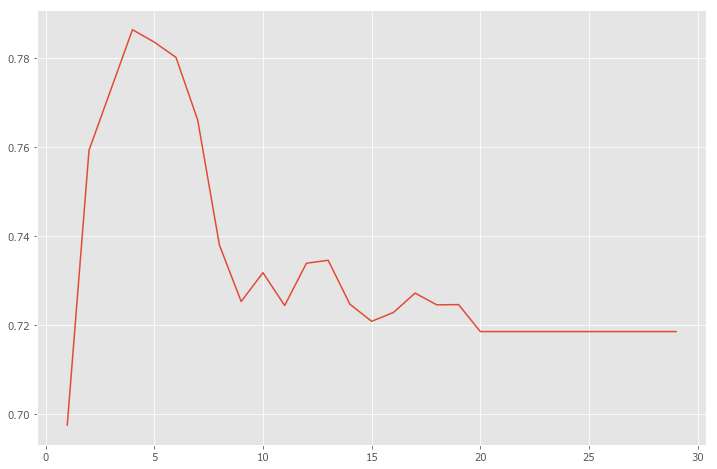

In [184]:
plt.plot(param_range, scores)

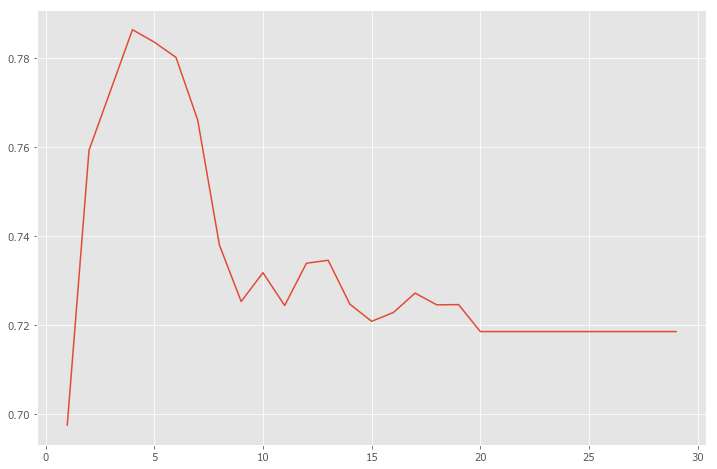

In [185]:
scores2, tst_scr = validation_curve(DecisionTreeClassifier(random_state=1234), x_t, y_t, "max_depth", param_range, scoring='roc_auc')
scores2_mean = scores2.mean(axis=1)
scores2_std = scores2.std(axis=1)
tst_scr_mean = tst_scr.mean(axis=1)
tst_scr_std = tst_scr.std(axis=1)
plt.plot(param_range, tst_scr_mean)

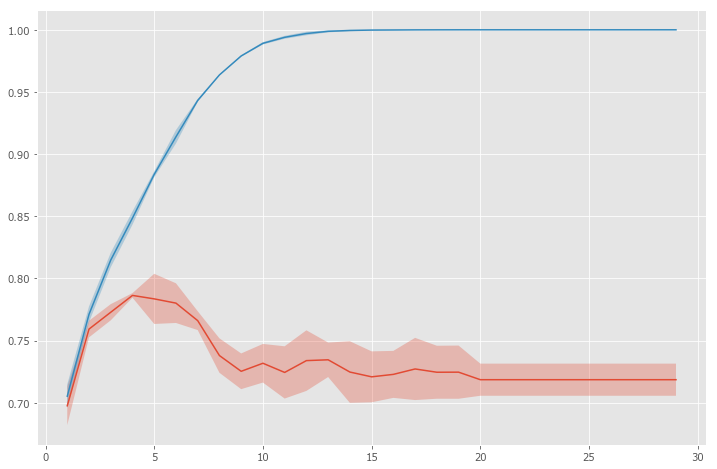

In [186]:
plt.plot(param_range, tst_scr_mean)
plt.fill_between(param_range, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
plt.plot(param_range, scores2_mean)
plt.fill_between(param_range, scores2_mean + scores2_std, scores2_mean - scores2_std, alpha=0.3)

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [187]:
d = 4

In [188]:
model = DecisionTreeClassifier(random_state=1234, max_depth=d)

In [189]:
model = model.fit(x_t, y_t)

In [190]:
idx = model.feature_importances_.argsort()
imp_features = x_t.columns[idx]

In [191]:
imp_features = imp_features[::-1]

In [192]:
print imp_features.values

['alcohol' 'sulphates' 'volatile acidity' 'fixed acidity'
 'total sulfur dioxide' 'chlorides' 'pH' 'density' 'free sulfur dioxide'
 'residual sugar' 'citric acid']


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [193]:
y_proba = model.predict_proba(x_test)

In [194]:
from sklearn.metrics import roc_curve, auc

In [195]:
def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    print 'ROC curve area for index 0 = %0.2f' % roc_auc
    plt.fill_between(fpr, tpr, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print 'ROC curve area for index 1 = %0.2f' % roc_auc
    plt.fill_between(fpr, tpr, alpha=0.3)

ROC кривая для обучающей выборки

ROC curve area for index 0 = 0.83
ROC curve area for index 1 = 0.83


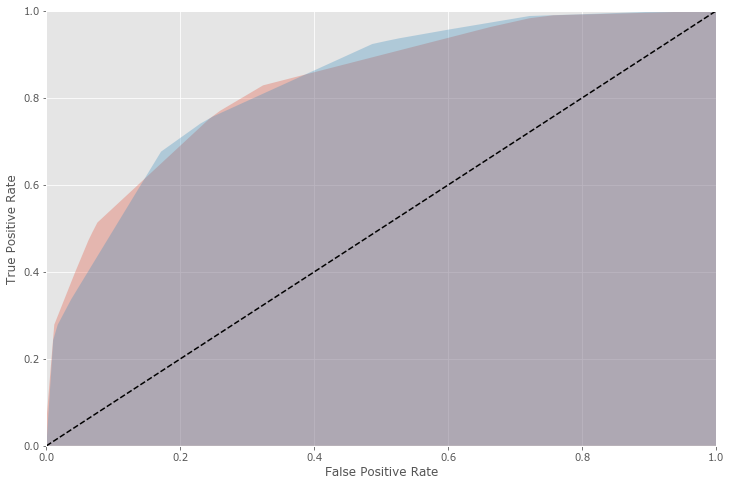

In [196]:
plot_roc_curve(y_t, model.predict_proba(x_t))

ROC кривая для тестовой выборки

ROC curve area for index 0 = 0.79
ROC curve area for index 1 = 0.79


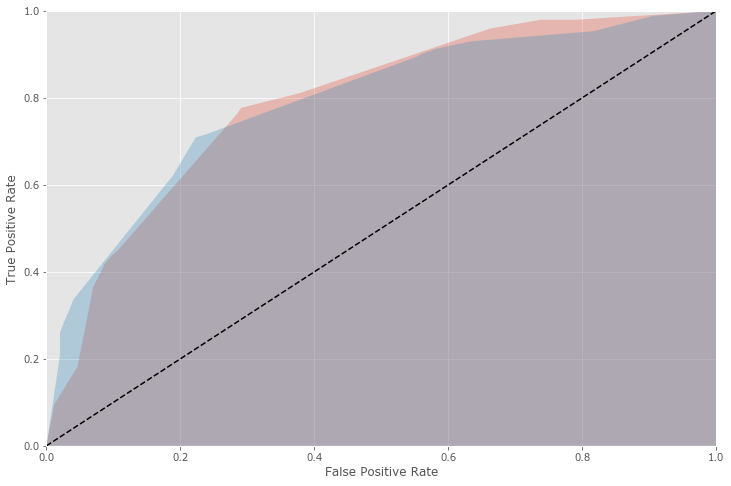

In [197]:
plot_roc_curve(y_test, y_proba)

Другие меры качества

In [198]:
y_pred_test = y_proba[:, 1] > 0.5
y_pred_train = model.predict_proba(x_t)[:, 1] > 0.5 

In [199]:
print 'Train scores: '
print 'Accuracy score: ', metrics.accuracy_score(y_t, y_pred_train)
print 'F1 score: ', metrics.f1_score(y_t, y_pred_train)
print 'Precision: ', metrics.precision_score(y_t, y_pred_train)
print 'Recall: ', metrics.recall_score(y_t, y_pred_train)
print '\nTest scores: '
print 'Accuracy score: ', metrics.accuracy_score(y_test, y_pred_test)
print 'F1 score: ', metrics.f1_score(y_test, y_pred_test)
print 'Precision: ', metrics.precision_score(y_test, y_pred_test)
print 'Recall: ', metrics.recall_score(y_test, y_pred_test)

Train scores: 
Accuracy score:  0.754495699765
F1 score:  0.763197586727
Precision:  0.786936236392
Recall:  0.740849194729

Test scores: 
Accuracy score:  0.740625
F1 score:  0.746177370031
Precision:  0.787096774194
Recall:  0.709302325581


#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [200]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [201]:
simple_tree = DecisionTreeClassifier(max_depth=d, random_state=1234)

In [202]:
simple_tree = simple_tree.fit(x_t, y_t)

In [203]:
simple_pred = simple_tree.predict(x_test)

In [204]:
print 'Accuracy score: ', metrics.accuracy_score(y_test, simple_pred)

Accuracy score:  0.740625


In [205]:
trees = xrange(1,11)

([<matplotlib.axis.XTick at 0x109af2050>,
 <a list of 10 Text xticklabel objects>)

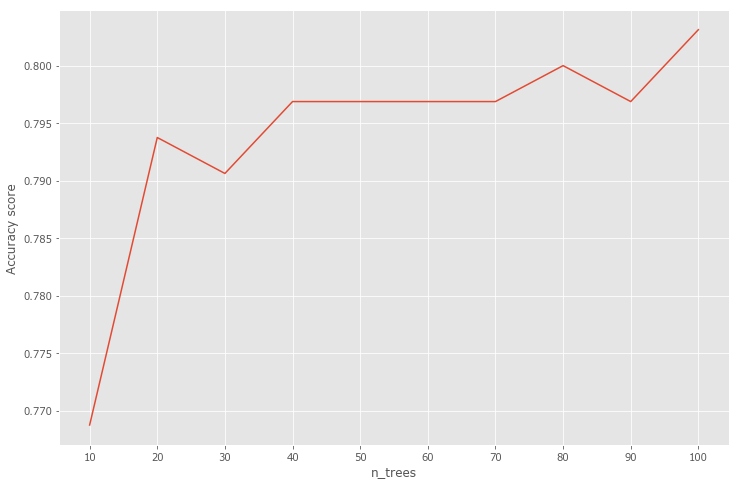

In [206]:
bag_scores = np.empty(10)
for n in trees:
    bag_tree = BaggingClassifier(simple_tree, n_estimators=n*10, random_state=1234)
    bag_tree = bag_tree.fit(x_t, y_t)
    bag_pred = bag_tree.predict(x_test)
    bag_scores[n-1] = metrics.accuracy_score(y_test, bag_pred)
plt.plot(xrange(10), bag_scores)
plt.xlabel('n_trees')
plt.ylabel('Accuracy score')
plt.xticks(xrange(10), xrange(10, 101, 10))

([<matplotlib.axis.XTick at 0x10a410190>,
 <a list of 10 Text xticklabel objects>)

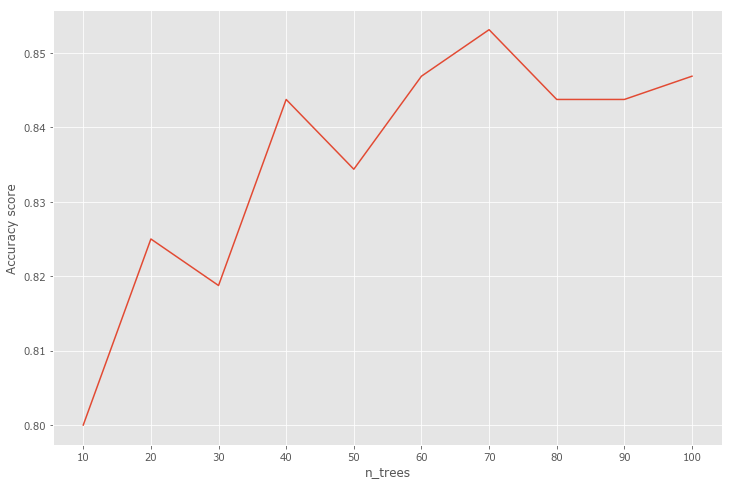

In [207]:
randf_scores = np.empty(10)
for n in trees:
    randf_tree = RandomForestClassifier(n_estimators=n*10, random_state=1234)
    randf_tree = randf_tree.fit(x_t, y_t)
    randf_pred = randf_tree.predict(x_test)
    randf_scores[n-1] = metrics.accuracy_score(y_test, randf_pred)
plt.plot(xrange(10), randf_scores)
plt.xlabel('n_trees')
plt.ylabel('Accuracy score')
plt.xticks(xrange(10), xrange(10, 101, 10))

Для обычного дерева мы видили, что score равен 0.740625. Из графиков видно, что макс точночти у Bagging около 0.80, а у Random Forest около 0.85. И то, и другое значение больше, чем у простого дерева.

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [208]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [209]:
gr = GridSearchCV(RandomForestClassifier(random_state=1234), {'n_estimators': range(10, 101, 10), 'max_depth': range(1, 21), 'criterion': ['gini', 'entropy']})

In [210]:
gr.fit(x_t, y_t)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [211]:
gr.best_params_

{'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 60}

In [212]:
rs = RandomizedSearchCV(RandomForestClassifier(random_state=1234), {'n_estimators': range(10, 101, 10), 'max_depth': range(1, 21), 'criterion': ['gini', 'entropy']})

In [213]:
rs.fit(x_t, y_t)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [214]:
rs.best_params_

{'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 80}

In [215]:
rs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False)

Кроссвалидация для наилучших параметров GridSearchCV и RandomizedSearchCV

In [216]:
cross_val_score(gr.best_estimator_, x_t, y_t, scoring='roc_auc').mean()

0.86850629602879137

In [217]:
cross_val_score(rs.best_estimator_, x_t, y_t, scoring='roc_auc').mean()

0.86818718642295722

Качество на тестовой выборке

In [218]:
metrics.accuracy_score(y_test, gr.best_estimator_.predict(x_test))

0.83437499999999998

In [219]:
metrics.accuracy_score(y_test, rs.best_estimator_.predict(x_test))

0.84062499999999996

Как видно из результатов, у параметров из GridSearchCV качество на кроссвалидации лучше, чем у RandomizedSearchCV. Однако у параметров из RandomizedSearchCV качество на тестовой выборке лучше, чем у GridSearchCV. Но в общем результаты не сильно отличаются.